# Import Library

In [80]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler,  RobustScaler
from sklearn.model_selection import train_test_split
########################
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dropout
from keras.utils import to_categorical

import os
import zipfile

In [81]:
local_zip = 'only_manual_data.zip'
#           '/Users/falesr/Box Sync/NICU Box/Xuefeng Hou NICU Work/Forcasting Paper/Plots/Python data/only_manual_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('.')
zip_ref.close()

# Define our example directories and files
base_dir = '/only_manual_data1'

# Load data

In [82]:
third_masimo_logging_data = pd.read_csv('./only_manual_data/08-02-18Masimo_logging.txt',
                  sep='\t')
third_spacelab_logging_data = pd.read_csv('./only_manual_data/08-02-18SpaceLabs_logging.txt',
                                 sep = '\t')

In [84]:
third_masimo_data_M1 = pd.read_csv('./only_manual_data/08-03-2018Analog_SpO2_PR_Masimo_M1.txt',
                  sep='\t')
third_spacelab_data_M1 = pd.read_csv('./only_manual_data/08-03-18clinical_SpaceLabs_easy_M1.txt',
                                 sep = '\t')

In [85]:
third_masimo_data_M2 = pd.read_csv('./only_manual_data/08-03-2018Analog_SpO2_PR_Masimo_M2.txt',
                  sep='\t')
third_spacelab_data_M2 = pd.read_csv('./only_manual_data/08-03-18clinical_SpaceLabs_easy_M2.txt',
                                 sep = '\t')

In [86]:
fourth_masimo_logging_data = pd.read_csv('./only_manual_data/08-18-18Masimo_logging.txt',
                  sep='\t')
fourth_spacelab_logging_data = pd.read_csv('./only_manual_data/08-18-18SpaceLabs_logging.txt',
                                 sep = '\t')

In [87]:
fourth_masimo_data_M1 = pd.read_csv('./only_manual_data/08-19-2018Analog_SpO2_PR_Masimo_M1.txt',
                  sep='\t')
fourth_spacelab_data_M1 = pd.read_csv('./only_manual_data/08-19-18clinical_SpaceLabs_easy_M1.txt',
                                 sep = '\t')

In [88]:
fourth_masimo_data_M2 = pd.read_csv('./only_manual_data/08-19-2018Analog_SpO2_PR_Masimo_M2.txt',
                  sep='\t')
fourth_spacelab_data_M2 = pd.read_csv('./only_manual_data/08-19-18clinical_SpaceLabs_easy_M2.txt',
                                 sep = '\t')

In [89]:
fifth_masimo_logging_data = pd.read_csv('./only_manual_data/08-30-18Masimo_logging.txt',
                  sep='\t')
fifth_spacelab_logging_data = pd.read_csv('./only_manual_data/08-30-18SpaceLabs_logging.txt',
                                 sep = '\t')

In [90]:
fifth_masimo_data_M1 = pd.read_csv('./only_manual_data/08-31-2018Analog_SpO2_PR_Masimo_M1.txt',
                  sep='\t')
fifth_spacelab_data_M1 = pd.read_csv('./only_manual_data/08-31-18clinical_SpaceLabs_easy_M1.txt',
                                 sep = '\t')

In [91]:
fifth_masimo_data_M2 = pd.read_csv('./only_manual_data/08-31-2018Analog_SpO2_PR_Masimo_M2.txt',
                  sep='\t')
fifth_spacelab_data_M2 = pd.read_csv('./only_manual_data/08-31-18clinical_SpaceLabs_easy_M2.txt',
                                 sep = '\t')

In [92]:
sixth_masimo_logging_data = pd.read_csv('./only_manual_data/09-25-18Masimo_logging.txt',
                  sep='\t')
sixth_spacelab_logging_data = pd.read_csv('./only_manual_data/09-25-18SpaceLabs_logging.txt',
                                 sep = '\t')

In [93]:
sixth_masimo_data_M1 = pd.read_csv('./only_manual_data/09-26-2018Analog_SpO2_PR_Masimo_M1.txt',
                  sep='\t')
sixth_spacelab_data_M1 = pd.read_csv('./only_manual_data/09-26-18clinical_SpaceLabs_easy_M1.txt',
                                 sep = '\t')

In [37]:
sixth_masimo_data_M2 = pd.read_csv('./only_manual_data/09-26-2018Analog_SpO2_PR_Masimo_M2.txt',
                  sep='\t')
sixth_spacelab_data_M2 = pd.read_csv('./only_manual_data/09-26-18clinical_SpaceLabs_easy_M2.txt',
                                 sep = '\t')

# Define data manipulation pipeline function

In [94]:
def data_manipulation(masimo_data, 
                      spacelab_data, 
                      upperlimit, 
                      lowerlimit, 
                      long = 60,
                      n = 2,
                      m = 1,
                      N_train = 'all',
                      strategy = 'strategy1'):
    """
    Data manipulation function, to clean raw clinical data, construct the ready-to-use data struction.
    masimo_data: data file logged from Masimo
    spacelab_data: data file logged from spacelab
    upperlimit: SpO2 target range upper limit
    lowerlimit: SpO2 target range lower limit
    long: the size of each small piece after segmenting the whole series
    n: Number of pieces of data used for making a alarm forecasting, default is n = 2.
    m: Number of windows in the future the forecasting is made for, this is also the step size of windows slide to the future, default is m = 1.
    N_train: the number of pieces used as training dataset, default is all pieces, N_train = N_piece
    strategy: data labelling strategy. 'strategy1' is beyond limit for 10 seconds; 'strategy2' is 50 SatSeconds. By default,  strategy = 'strategy1'
    
    """
    # Get each variables from raw datasets
    ANLG_time = np.array(masimo_data['ANLG_time'])
    ANLG_MSM_SpO2 = np.array(masimo_data['ANLG_MSM_SpO2'])
    ANLG_MSM_PR = np.array(masimo_data['ANLG_MSM_PR'])

    spacelab_time = np.array(spacelab_data['C_S_time'])
    spacelab_FiO2 = np.array(spacelab_data['C_S_FiO2'])
    spacelab_HR = np.array(spacelab_data['C_S_HR'])
    spacelab_RR = np.array(spacelab_data['C_S_RR'])
    
    #Interpolate the missing points
    def missing_elements(L):
        start, end = L[0], L[-1]
        return sorted(set(range(start, end + 1)).difference(L))
    ANLG_missing_time = missing_elements(ANLG_time)
    spacelab_missing_time = missing_elements(spacelab_time)
    
    # search for duplicates
    aa = set(item for item, count in collections.Counter(spacelab_time).items() if count > 1)
    if len(aa) != 0:
        sys.exit('There are duplicated data, please check the raw data file and remove the duplicated ones!')
    
    for i in ANLG_missing_time:
        ANLG_MSM_SpO2 = np.insert(ANLG_MSM_SpO2,i,ANLG_MSM_SpO2[i-1])
        ANLG_MSM_PR = np.insert(ANLG_MSM_PR,i,ANLG_MSM_PR[i-1])
    size_ANLG = len(ANLG_MSM_PR)
    
    for i in spacelab_missing_time:
        spacelab_FiO2 = np.insert(spacelab_FiO2,i,spacelab_FiO2[i-1])
        spacelab_HR = np.insert(spacelab_HR,i,spacelab_HR[i-1])
        spacelab_RR = np.insert(spacelab_RR,i,spacelab_RR[i-1])
    size_spacelab = len(spacelab_FiO2)
    
    size = min(size_ANLG,size_spacelab)
    
    # Get the variables interpolated and masimo data and spacelab data share the same size
    ANLG_MSM_SpO2 = ANLG_MSM_SpO2[0:size]
    ANLG_MSM_PR = ANLG_MSM_PR[0:size]
    spacelab_FiO2 = spacelab_FiO2[0:size]
    spacelab_HR = spacelab_HR[0:size]
    spacelab_RR = spacelab_RR[0:size]
    
    # Correct SpO2 based on Heart Rate and Pulse Rate disagreement
    #SpO2 = np.zeros(size)
    #SpO2[0] = ANLG_MSM_SpO2[0]

    #for i in np.arange(1, size, 1):
    #    if abs(spacelab_HR[i]-ANLG_MSM_PR[i]) > 5:
    #        SpO2[i] = SpO2[i-1]
    #    else:
    #        SpO2[i] = ANLG_MSM_SpO2[i]
    
    SpO2 = ANLG_MSM_SpO2.copy()
    # Construct Data Frame
    PR = ANLG_MSM_PR.copy()
    FiO2 = spacelab_FiO2.copy()
    RR = spacelab_RR.copy()
    dataframe = pd.DataFrame({'SpO2':SpO2, 'PR':PR, 'FiO2':FiO2, 'RR':RR})
    
    # Label each data point with alarm status
    if strategy == 'strategy1':
        u_count = 0
        l_count = 0
        AL = np.zeros(size)
        for i in np.arange(0,size,1):
            if dataframe['SpO2'][i] < lowerlimit:
                l_count += 1
                u_count = 0
                if l_count >= 10:
                    AL[i] = -1
                else:
                    AL[i] = 0
            elif dataframe['SpO2'][i] > upperlimit:
                u_count += 1
                l_count = 0
                if u_count >= 10:
                    AL[i] = 1
                else:
                    AL[i] = 0
    elif strategy == 'strategy2':
        u_count = 0
        l_count = 0
        AL = np.zeros(size)
        for i in np.arange(0,size,1):
            if dataframe['SpO2'][i] < lowerlimit:
                dif_l_count = dataframe['SpO2'][i] - lowerlimit
                l_count = l_count + dif_l_count
                u_count = 0
                if l_count <= -50:
                    AL[i] = -1
                else:
                    AL[i] = 0
            elif dataframe['SpO2'][i] > upperlimit:
                dif_u_count = dataframe['SpO2'][i] - upperlimit
                u_count = u_count + dif_u_count
                l_count = 0
                if u_count >= 50:
                    AL[i] = 1
                else:
                    AL[i] = 0
                    
    # Concatenate dataframe with AL(alarm label)
    AL = pd.DataFrame({'AL':AL})
    data_AL_df = pd.concat([dataframe, AL],axis=1)
    
    # Piecewise the AL
    N_piece = len(data_AL_df['SpO2'])//long
    last_piece = len(data_AL_df['SpO2'])%long
    x_axis = np.arange(0,long,1)
    #SpO2_piece = np.zeros((N_piece,long))
    #AL_piece = np.zeros((N_piece,long))
    #for i in np.arange(0,N_piece,1):
            #SpO2_piece[i,] = data_AL_df['SpO2'][long*i:long*(i+1)]
            #AL_piece[i,] = data_AL_df['AL'][long*i:long*(i+1)]
            
    # Add alarm label to piecewise data
    def label_piecewise_data(alarm_piece):
        uni_alarm = np.unique(alarm_piece)
        if len(uni_alarm) == 1:
            LD = uni_alarm[0]
        elif len(uni_alarm) == 2:
            if uni_alarm[0] == -1 and uni_alarm[1] == 0:
                LD = uni_alarm[0]
            elif uni_alarm[0] == 0 and uni_alarm[1] == 1:
                LD = uni_alarm[1]
        else:
            LD = alarm_piece[np.max(np.nonzero(alarm_piece))]
        return LD
    
    #LD = np.array([label_piecewise_data(p) for p in AL_piece])
    #LD = LD.reshape((N_piece,1))
    
    # Prepare training dataset
    training_feature = data_AL_df.iloc[:,0:4].values
    
    # Feature scaling
    sc = MinMaxScaler(feature_range = (0, 1)) # scale between 0 and 1
    #sc = StandardScaler()
    training_feature_scaled = sc.fit_transform(training_feature)
    
    # Creating a data structure with n small windows as inputs and 1 output(prediction of following m small windows)
    X_train = []
    y_train = []
    AL_piece = []

    if N_train == 'all':
        for i in np.arange(n,N_piece,m): # N_piece = 729, use 700 pieces for training
            X_train.append(training_feature[(i-n)*long:i*long, 0:4])
            AL_piece.append(AL.values[i*long:(i+m)*long, 0])
            #y_train.append(LD[i, 0])
        y_train = np.array([label_piecewise_data(p) for p in AL_piece])
        #y_train = y_train.reshape((N_piece,1))
    else:
        for i in np.arange(n,N_train,m): 
            X_train.append(training_feature[(i-n)*long:i*long, 0:4])
            AL_piece.append(AL.values[i*long:(i+m)*long, 0])
            #y_train.append(LD[i, 0])
        y_train = np.array([label_piecewise_data(p) for p in AL_piece])
        #y_train = y_train.reshape((N_train,1))

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
    
    return X_train, y_train

# Function that process all datasets

In [95]:
def combine_datasets(piece_size = 60,
                    num_piece_pred = 2,
                    num_piece_resp = 1,
                    label_strategy = 'strategy1'):
    # The third patient data
    third_logging_X_train, third_logging_y_train = data_manipulation(masimo_data = third_masimo_logging_data, 
                                      spacelab_data = third_spacelab_logging_data, 
                                      upperlimit = 99, 
                                      lowerlimit = 91, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    
    third_X_train_M1, third_y_train_M1 = data_manipulation(masimo_data = third_masimo_data_M1, 
                                      spacelab_data = third_spacelab_data_M1, 
                                      upperlimit = 99, 
                                      lowerlimit = 91, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    
    third_X_train_M2, third_y_train_M2 = data_manipulation(masimo_data = third_masimo_data_M2, 
                                      spacelab_data = third_spacelab_data_M2, 
                                      upperlimit = 99, 
                                      lowerlimit = 91, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    # The fourth patient data
    fourth_logging_X_train, fourth_logging_y_train = data_manipulation(masimo_data = fourth_masimo_logging_data, 
                                      spacelab_data = fourth_spacelab_logging_data, 
                                      upperlimit = 99, 
                                      lowerlimit = 91, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    
    fourth_X_train_M1, fourth_y_train_M1 = data_manipulation(masimo_data = fourth_masimo_data_M1, 
                                      spacelab_data = fourth_spacelab_data_M1, 
                                      upperlimit = 99, 
                                      lowerlimit = 91, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    
    fourth_X_train_M2, fourth_y_train_M2 = data_manipulation(masimo_data = fourth_masimo_data_M2, 
                                      spacelab_data = fourth_spacelab_data_M2, 
                                      upperlimit = 99, 
                                      lowerlimit = 91, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    # The fifth patient data
    fifth_logging_X_train, fifth_logging_y_train = data_manipulation(masimo_data = fifth_masimo_logging_data, 
                                      spacelab_data = fifth_spacelab_logging_data, 
                                      upperlimit = 99, 
                                      lowerlimit = 91, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    
    fifth_X_train_M1, fifth_y_train_M1 = data_manipulation(masimo_data = fifth_masimo_data_M1, 
                                      spacelab_data = fifth_spacelab_data_M1, 
                                      upperlimit = 99, 
                                      lowerlimit = 91, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    
    fifth_X_train_M2, fifth_y_train_M2 = data_manipulation(masimo_data = fifth_masimo_data_M2, 
                                      spacelab_data = fifth_spacelab_data_M2, 
                                      upperlimit = 99, 
                                      lowerlimit = 91, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    # The sixth patient data
    sixth_logging_X_train, sixth_logging_y_train = data_manipulation(masimo_data = sixth_masimo_logging_data, 
                                      spacelab_data = sixth_spacelab_logging_data, 
                                      upperlimit = 95, 
                                      lowerlimit = 87, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    sixth_X_train_M1, sixth_y_train_M1 = data_manipulation(masimo_data = sixth_masimo_data_M1, 
                                      spacelab_data = sixth_spacelab_data_M1, 
                                      upperlimit = 95, 
                                      lowerlimit = 87, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    
    sixth_X_train_M2, sixth_y_train_M2 = data_manipulation(masimo_data = sixth_masimo_data_M2, 
                                      spacelab_data = sixth_spacelab_data_M2, 
                                      upperlimit = 95, 
                                      lowerlimit = 87, 
                                      long = piece_size,
                                      n = num_piece_pred,
                                      m = num_piece_resp,
                                      N_train = 'all',
                                      strategy = label_strategy)
    # Concatenate all training datasets
    X_all = np.concatenate((third_logging_X_train,third_X_train_M1,third_X_train_M2,fourth_logging_X_train,fourth_X_train_M1,fourth_X_train_M2,fifth_logging_X_train,fifth_X_train_M1,fifth_X_train_M2))
    y_all = np.concatenate((third_logging_y_train,third_y_train_M1,third_y_train_M2,fourth_logging_y_train,fourth_y_train_M1,fourth_y_train_M2,fifth_logging_y_train,fifth_y_train_M1,fifth_y_train_M2))
    
    return X_all, y_all


In [96]:
X_all, y_all = combine_datasets(piece_size = 60,
                                    num_piece_pred = 2,
                                    num_piece_resp = 1,
                                    label_strategy = 'strategy1')

In [97]:
X_all.shape

(3466, 120, 4)

In [98]:
sum(y_all[y_all == 1])

899.0

In [99]:
sum(y_all[y_all == -1])

-1115.0

In [100]:
np.count_nonzero(y_all==0)

1452

In [101]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.15, random_state = 5, shuffle= True)

In [102]:
X_train.shape

(2946, 120, 4)

In [103]:
X_test.shape

(520, 120, 4)

In [104]:
sum(y_train[y_train == 1])

765.0

In [105]:
sum(y_train[y_train == -1])

-938.0

In [106]:
np.count_nonzero(y_train==0)

1243

In [107]:
sum(y_test[y_test == 1])

134.0

In [108]:
sum(y_test[y_test == -1])

-177.0

In [109]:
np.count_nonzero(y_test==0)

209

# Define building RNN pipeline function

In [ ]:
def build_LSTM(X_train,
              y_train,
              num_lstm_layer = 1,
              dropout_rate = 0.2,
              num_units = [64],
              num_epochs = 10,
              num_batches = 32,
              percent_validation = 0.2):
    """
    build_LSTM function is designed to construct the Long-Short-Term-Memory neural networks.
    
    X_train: The input features of training dataset
    y_train: The output labels of training dataset
    num_lstm_layer: The number of LSTM neural networks layers, default is num_lstm_layer = 1
    dropout_rate: To reduce over-fitting, some neurons will be dropped out, default is dropout_rate = 0.2
    num_units: The number of neurons for each layer, the input here should be a vector, the length of the vector should match the number of layers. Default is num_units = [64]
    num_epochs: The number of epochs, the number of complete passes through the training dataset
    num_batches: The batch size, the number of samples processed before the model is updated
    """
    class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.75):
          if(logs.get('accuracy') > 0.76):
            print("\nReached 75% accuracy for validation, so cancelling training!")
            self.model.stop_training = True

    callbacks = myCallback()
    
    # one-hot encoding the y_train data
    categorical_y_train = to_categorical(y_train, num_classes=3)
    
    # Initialising the RNN
    classifier = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    classifier.add(LSTM(units = num_units[0], return_sequences = True, activation = 'tanh', input_shape = (X_train.shape[1], 4))) 
    # return_sequences = True because we will stack several LSTM layers, input_shape only for first layer, and is the last two dimensions of training set
    classifier.add(Dropout(dropout_rate))
    
    if num_lstm_layer == 0:
        sys.exit('The number of LSTM layers is at least one!')
    
    if num_lstm_layer == 2:
        # Adding a second LSTM layer and some Dropout regularisation
        classifier.add(LSTM(units = num_units[1], activation = 'tanh'))
    elif num_lstm_layer > 2:
        classifier.add(LSTM(units = num_units[1], return_sequences = True, activation = 'tanh'))
    classifier.add(Dropout(dropout_rate))
    
    if num_lstm_layer == 3:
        # Adding a third LSTM layer and some Dropout regularisation
        classifier.add(LSTM(units = num_units[2], activation = 'tanh'))
    elif num_lstm_layer > 3:
        classifier.add(LSTM(units = num_units[2], return_sequences = True, activation = 'tanh'))
    classifier.add(Dropout(dropout_rate))

    if num_lstm_layer == 4:
        # Adding a third LSTM layer and some Dropout regularisation
        classifier.add(LSTM(units = num_units[3], activation = 'tanh'))
    elif num_lstm_layer > 4:
        classifier.add(LSTM(units = num_units[3], return_sequences = True, activation = 'tanh'))
    classifier.add(Dropout(dropout_rate))

    if num_lstm_layer == 5:
        # Adding a third LSTM layer and some Dropout regularisation
        classifier.add(LSTM(units = num_units[4], activation = 'tanh'))
    elif num_lstm_layer > 5:
        classifier.add(LSTM(units = num_units[4], return_sequences = True, activation = 'tanh'))
    classifier.add(Dropout(dropout_rate))

    if num_lstm_layer == 6:
        # Adding a third LSTM layer and some Dropout regularisation
        classifier.add(LSTM(units = num_units[5], activation = 'tanh'))
    elif num_lstm_layer > 6:
        classifier.add(LSTM(units = num_units[5], return_sequences = True, activation = 'tanh'))
    classifier.add(Dropout(dropout_rate))

    if num_lstm_layer == 7:
        # Adding a fourth LSTM layer and some Dropout regularisation
        classifier.add(LSTM(units = num_units[6], activation = 'tanh'))
    classifier.add(Dropout(dropout_rate))

    if num_lstm_layer > 7:
        sys.exit('The number of LSTM layers is designed at most 7. Want more layers, please edit the build_LSTM function!')
        
    # Adding the output layer
    classifier.add(Dense(units = 3, activation='softmax'))

    # Compiling the RNN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    # Fitting the RNN to the Training set
    classifier.fit(X_train, categorical_y_train, epochs = num_epochs, batch_size = num_batches, validation_split = percent_validation, callbacks=[callbacks])
    
    return classifier


In [ ]:
desat_model = build_LSTM(X_train = X_train,
                      y_train = y_train,
                      num_lstm_layer = 4,
                      dropout_rate = 0.2,
                      num_units = [256,256,256,256],
                      num_epochs = 400,
                      num_batches = 64,
                      percent_validation = 0.2)
desat_model

Epoch 1/400
37/37 [==============================] - 4s 110ms/step - loss: 1.0213 - accuracy: 0.4648 - val_loss: 0.9264 - val_accuracy: 0.5203
Epoch 2/400
37/37 [==============================] - 2s 63ms/step - loss: 0.9429 - accuracy: 0.5110 - val_loss: 0.8948 - val_accuracy: 0.5678
Epoch 3/400
37/37 [==============================] - 2s 63ms/step - loss: 0.8998 - accuracy: 0.5399 - val_loss: 0.8430 - val_accuracy: 0.6051
Epoch 4/400
37/37 [==============================] - 2s 63ms/step - loss: 0.8725 - accuracy: 0.5866 - val_loss: 0.8064 - val_accuracy: 0.6492
Epoch 5/400
37/37 [==============================] - 2s 62ms/step - loss: 0.8593 - accuracy: 0.5963 - val_loss: 0.7723 - val_accuracy: 0.6966
Epoch 6/400
37/37 [==============================] - 2s 62ms/step - loss: 0.8533 - accuracy: 0.5951 - val_loss: 0.8148 - val_accuracy: 0.6085
Epoch 7/400
37/37 [==============================] - 2s 63ms/step - loss: 0.8721 - accuracy: 0.5734 - val_loss: 0.7540 - val_accuracy: 0.6407
Epoch

Final model results: after 126 epochs, loss: 0.5276 - accuracy: 0.7661 - val_loss: 0.5772 - val_accuracy: 0.7610

Best models:
1. n=4, units=512,512,512,512. epochs=400
loss: 0.5847 - acc: 0.7280 - val_loss: 0.5323 - val_acc: 0.7754
2. n=2, units=256,256,256,256. loss: 0.6026 - accuracy: 0.7360 - val_loss: 0.5668 - val_accuracy: 0.7542. Test: 0.6103, 0.7231
3. n=2, units=256,256,256,256.loss: 0.5384 - accuracy: 0.7649 - val_loss: 0.5849 - val_accuracy: 0.7576. Test: 0.6084, 0.7481

# Save trained model

In [78]:
# serialize weights to HDF5
desat_model.save('/tmp/alarm_forecasting_model.h5')

AttributeError: 'File' object has no attribute 'save'

In [77]:
# serialize model to JSON
desat_model_json = desat_model.to_json()

with open("./alarm_forecasting_model.json", "w") as json_file:
    json_file.write(desat_model_json)

AttributeError: 'File' object has no attribute 'to_json'

In [68]:
desat_model.metrics_names

AttributeError: 'File' object has no attribute 'metrics_names'

In [67]:
max(desat_model.history.history['val_accuracy'])

AttributeError: 'File' object has no attribute 'history'

# Training loss vs. Validation loss plot

In [61]:
loss_values = desat_model.history.history['loss']
val_loss_values = desat_model.history.history['val_loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs,loss_values)
plt.plot(epochs,val_loss_values)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

AttributeError: 'Sequential' object has no attribute 'history'

# Training accuracy vs. Validation accuracy plot

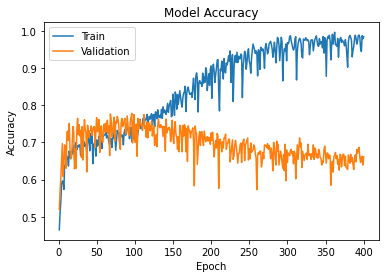

In [ ]:
acc_values = desat_model.history.history['accuracy']
val_acc_values = desat_model.history.history['val_accuracy']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs,acc_values)
plt.plot(epochs,val_acc_values)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save results to csv file

In [ ]:
import csv  
    
# field names  
fields = ['loss_values', 'val_loss_values', 'acc_values', 'val_acc_values'] 

rows = zip(loss_values, val_loss_values, acc_values,val_acc_values)
# name of csv file  
filename = "/tmp/overtraining_loss_accuracy.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(fields)  
    for row in rows:    
      # writing the data rows  
      csvwriter.writerow(row) 

In [ ]:
import csv  
# field names  
fields = ['loss_values', 'val_loss_values', 'acc_values', 'val_acc_values'] 

rows = zip(loss_values, val_loss_values, acc_values,val_acc_values)
# name of csv file  
filename = "/tmp/final_model_loss_accuracy.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(fields)  
    for row in rows:    
      # writing the data rows  
      csvwriter.writerow(row) 

# Prepare test dataset

In [ ]:
#X_test, y_test = data_manipulation(masimo_data = fifth_masimo_logging_data,
#                                      spacelab_data = fifth_spacelab_logging_data,
#                                      upperlimit = 99,
#                                      lowerlimit = 91,
#                                      long = 60,
#                                      n = 2,
#                                      m = 1,
#                                      N_train = 'all',
#                                      strategy = 'strategy1')

In [ ]:
#sum(y_test[y_test == 1])

In [ ]:
#sum(y_test[y_test == -1])

In [ ]:
#y_test.shape

# Load trained model

In [110]:
# keras library import  for Saving and loading model and weights

from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.models import load_model

# load json and create model
json_file = open('./alarm_forecasting_model.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
desat_model = model_from_json(loaded_model_json)

# load weights into new model
desat_model.load_weights("./alarm_forecasting_model.h5")
print("Loaded model from disk")

desat_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

Loaded model from disk


# Evaluate on test dataset

In [111]:
predicted_labels = desat_model.predict(X_test)
categorical_y_test = to_categorical(y_test, num_classes=3)
desat_model.evaluate(X_test,categorical_y_test)

520/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.6114927250605363, 0.74230766]

In [112]:
desat_model.predict(X_all[2664:2665])

array([[2.8783104e-01, 6.4108748e-04, 7.1152782e-01]], dtype=float32)

In [113]:
desat_model.predict(X_all[2705:2706])

array([[0.3443665 , 0.00135368, 0.65427977]], dtype=float32)

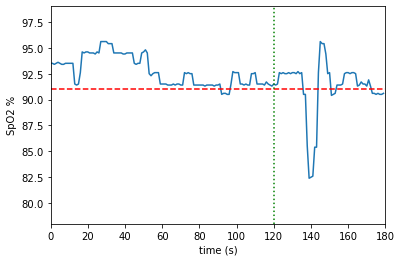

In [114]:
# Successful prediction of desaturation
plt.plot(np.concatenate((X_all[2664:2665][0][:,0], X_all[2665:2666][0][:,0][60:120]), axis=0))
plt.plot([0, 180],[91, 91],'r--')
plt.plot([120,120],[78,99],'g:')
plt.ylabel('SpO2 %')
plt.xlabel('time (s)')
plt.xlim(0,180)
plt.ylim(78,99)
plt.show()

In [ ]:
# save data to csv
import csv  
# name of csv file  
filename = "/tmp/desaturation_example_1.csv"
data1 = np.concatenate((X_all[2664:2665][0][:,0], X_all[2665:2666][0][:,0][60:120]), axis=0)    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(data1)  

In [115]:
desat_model.predict(X_all[2309:2310])

array([[1.7542163e-01, 1.4996791e-04, 8.2442838e-01]], dtype=float32)

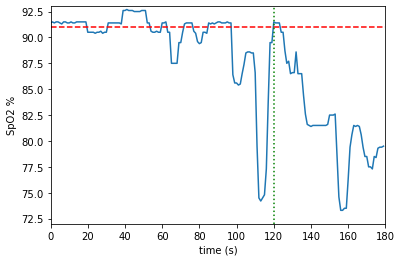

In [116]:
# Successful prediction of desaturation
plt.plot(np.concatenate((X_all[2309:2310][0][:,0], X_all[2310:2311][0][:,0][60:120]), axis=0))
plt.plot([0, 180],[91, 91],'r--')
plt.plot([120,120],[72,93],'g:')
plt.ylabel('SpO2 %')
plt.xlabel('time (s)')
plt.xlim(0,180)
plt.ylim(72,93)
plt.show()

In [ ]:
# save data to csv
import csv  
# name of csv file  
filename = "/tmp/desaturation_example_2.csv"
data2 = np.concatenate((X_all[2309:2310][0][:,0], X_all[2310:2311][0][:,0][60:120]), axis=0)   
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(data2) 

In [117]:
desat_model.predict(X_all[2050:2051])

array([[6.6060364e-01, 5.0500204e-04, 3.3889133e-01]], dtype=float32)

In [118]:
desat_model.predict(X_all[2874:2875])

array([[0.45858645, 0.50251025, 0.03890329]], dtype=float32)

In [119]:
desat_model.predict(X_all[2889:2890])

array([[0.37564573, 0.5804519 , 0.04390237]], dtype=float32)

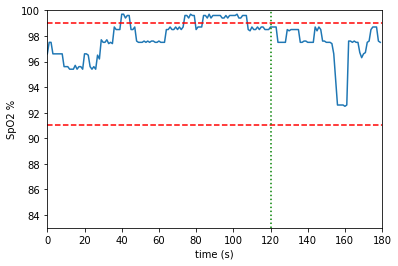

In [120]:
# Fales prediction of oversaturation
plt.plot(np.concatenate((X_all[2874:2875][0][:,0], X_all[2875:2876][0][:,0][60:120]), axis=0))
plt.plot([0, 180],[91, 91],'r--')
plt.plot([0, 180],[99, 99],'r--')
plt.plot([120,120],[83,100],'g:')
plt.ylabel('SpO2 %')
plt.xlabel('time (s)')
plt.xlim(0,180)
plt.ylim(83,100)
plt.show()

In [ ]:
# save data to csv
import csv  
# name of csv file  
filename = "/tmp/false_oversat_example.csv"
data3 = np.concatenate((X_all[2874:2875][0][:,0], X_all[2875:2876][0][:,0][60:120]), axis=0)   
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(data3) 

In [121]:
desat_model.predict(X_all[2056:2057])

array([[0.46893767, 0.03235071, 0.4987116 ]], dtype=float32)

In [122]:
desat_model.predict(X_all[2075:2076])

array([[0.7999326 , 0.01345657, 0.18661083]], dtype=float32)

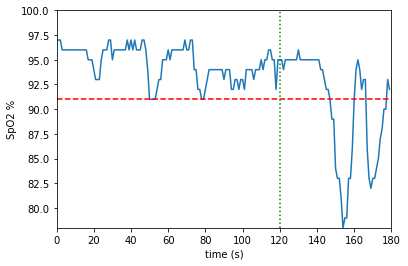

In [ ]:
# Fail to predict desaturation
plt.plot(np.concatenate((X_all[2075:2076][0][:,0], X_all[2076:2077][0][:,0][60:120]), axis=0))
plt.plot([0, 180],[91, 91],'r--')
plt.plot([120,120],[78,100],'g:')
plt.ylabel('SpO2 %')
plt.xlabel('time (s)')
plt.xlim(0,180)
plt.ylim(78,100)
plt.show()

In [ ]:
# save data to csv
import csv  
# name of csv file  
filename = "/tmp/miss_desat_example.csv"
data4 = np.concatenate((X_all[2075:2076][0][:,0], X_all[2076:2077][0][:,0][60:120]), axis=0)   
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(data4) 

In [123]:
categorical_y_test[0:10]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [124]:
y_test

array([-1.,  1., -1.,  0., -1., -1.,  1.,  0., -1.,  0.,  1.,  1.,  1.,
        0., -1.,  1.,  0.,  0.,  0.,  1.,  1., -1.,  1.,  1., -1., -1.,
        0.,  1.,  0.,  1.,  1.,  1., -1.,  0.,  0., -1.,  0.,  1.,  1.,
        0.,  1., -1., -1.,  1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1.,
       -1., -1.,  1., -1.,  0.,  0., -1.,  1.,  0.,  0., -1.,  0., -1.,
        0., -1., -1.,  0.,  1.,  1., -1.,  0.,  0., -1.,  0., -1.,  1.,
        0.,  0., -1., -1.,  1.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,
        0., -1., -1.,  0.,  0.,  1., -1., -1., -1.,  0.,  0.,  0.,  0.,
       -1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1., -1.,  0.,  0.,
       -1.,  1.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.,  1.,  0.,  0.,
        0., -1., -1.,  0.,  0.,  0.,  0., -1.,  1., -1.,  1.,  1.,  1.,
       -1.,  0., -1.,  0.,  0.,  0.,  0.,  1., -1., -1.,  0.,  0.,  1.,
        0.,  1.,  1., -1.,  0.,  1.,  0., -1.,  0., -1.,  0.,  1.,  0.,
       -1.,  0., -1., -1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1

In [125]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(categorical_y_test.argmax(axis=1), predicted_labels.argmax(axis=1)))

Confusion Matrix
[[176  17  16]
 [ 20 113   1]
 [ 77   3  97]]


In [126]:
categorical_y_test.argmax(axis=1)

array([2, 1, 2, 0, 2, 2, 1, 0, 2, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 1, 1, 2,
       1, 1, 2, 2, 0, 1, 0, 1, 1, 1, 2, 0, 0, 2, 0, 1, 1, 0, 1, 2, 2, 1,
       0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 2, 0, 0, 2, 1, 0, 0, 2, 0, 2, 0,
       2, 2, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 0, 0, 2, 2, 1, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0,
       0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 2, 1, 1, 0, 2, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 2,
       2, 1, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1, 0, 0,
       2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 1, 2, 1, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 1, 2, 1,
       0, 1, 0, 1, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2,
       1, 2, 1, 2, 0, 2, 1, 0, 0, 1, 2, 0, 0, 0, 0,

In [127]:
predicted_labels.argmax(axis=1)

array([0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 2, 0, 0, 2, 0, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0, 0, 2, 1, 1,
       0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 2, 2, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 0, 0, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0,
       0, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 1, 2, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 0, 2,
       2, 1, 0, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 1, 2, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 2, 0, 0, 1, 2,
       1, 2, 1, 2, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0,